# Predicting Attrition in Healthcare Workers

The goal of this project was to tackle employee attrition in the healthcare sector. Particularly, I wanted to answer two questions:
1. Which employees are likely to leave?
2. Can employee attrition be preemptively predicted?

To address these questions, I decided to train two machine learning models - an unsupervised model (clustering) to gain insight into different classes of attrited employes and a supervised model (classification) to predict employee attrition.

In [1]:
import os

# data manipulation & visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# unsupervised ml
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans 

# supervised ml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# configurations
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
# kaggle api credentials
creds = pd.read_csv('api_keys.csv')
kaggle_creds = creds[creds['NAME']=='kaggle']

os.environ['KAGGLE_USERNAME'] = kaggle_creds['USER'].values[0]
os.environ['KAGGLE_KEY'] = kaggle_creds['KEY'].values[0]

In [3]:
# downloading the dataset
! kaggle datasets download -d jpmiller/employee-attrition-for-healthcare

  0% 0.00/90.3k [00:00<?, ?B/s]
100% 90.3k/90.3k [00:00<00:00, 55.2MB/s]


In [4]:
# unzipping the file
! unzip employee-attrition-for-healthcare.zip

Archive:  employee-attrition-for-healthcare.zip
  inflating: watson_healthcare_modified.csv  
  inflating: watson_shap_values_for_testset.csv  


In [5]:
df = pd.read_csv('watson_healthcare_modified.csv')
df.head()

,EmployeeID,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,Shift,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1313919,41,No,Travel_Rarely,1102,Cardiology,1,2,Life Sciences,1,2,Female,94,3,2,Nurse,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,1200302,49,No,Travel_Frequently,279,Maternity,8,1,Life Sciences,1,3,Male,61,2,2,Other,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,1060315,37,Yes,Travel_Rarely,1373,Maternity,2,2,Other,1,4,Male,92,2,1,Nurse,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,1272912,33,No,Travel_Frequently,1392,Maternity,3,4,Life Sciences,1,4,Female,56,3,1,Other,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,1414939,27,No,Travel_Rarely,591,Maternity,2,1,Medical,1,1,Male,40,3,1,Nurse,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeID                1676 non-null   int64 
 1   Age                       1676 non-null   int64 
 2   Attrition                 1676 non-null   object
 3   BusinessTravel            1676 non-null   object
 4   DailyRate                 1676 non-null   int64 
 5   Department                1676 non-null   object
 6   DistanceFromHome          1676 non-null   int64 
 7   Education                 1676 non-null   int64 
 8   EducationField            1676 non-null   object
 9   EmployeeCount             1676 non-null   int64 
 10  EnvironmentSatisfaction   1676 non-null   int64 
 11  Gender                    1676 non-null   object
 12  HourlyRate                1676 non-null   int64 
 13  JobInvolvement            1676 non-null   int64 
 14  JobLevel                

__Insight:__ There are no null values in this dataset

In [7]:
# optional: lowering the case in the column names to for ease
df.columns = [x.lower() for x in df.columns]
df.head()

,employeeid,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,shift,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,1313919,41,No,Travel_Rarely,1102,Cardiology,1,2,Life Sciences,1,2,Female,94,3,2,Nurse,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,1200302,49,No,Travel_Frequently,279,Maternity,8,1,Life Sciences,1,3,Male,61,2,2,Other,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,1060315,37,Yes,Travel_Rarely,1373,Maternity,2,2,Other,1,4,Male,92,2,1,Nurse,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,1272912,33,No,Travel_Frequently,1392,Maternity,3,4,Life Sciences,1,4,Female,56,3,1,Other,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,1414939,27,No,Travel_Rarely,591,Maternity,2,1,Medical,1,1,Male,40,3,1,Nurse,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


## Feature Engineering

In [8]:
# listing the categorical columns
cat_cols = df.select_dtypes(include = 'object').columns.to_list()
cat_cols

['attrition',
 'businesstravel',
 'department',
 'educationfield',
 'gender',
 'jobrole',
 'maritalstatus',
 'over18',
 'overtime']

In [9]:
# label encoding for categorical colums 
print('-'*50,'Categorical label codes','-'*50)
for col in cat_cols:
  print(col+':', dict(enumerate(df[col].astype('category').cat.categories)), '\n')
  df[col] = df[col].astype('category').cat.codes

-------------------------------------------------- Categorical label codes --------------------------------------------------
attrition: {0: 'No', 1: 'Yes'} 

businesstravel: {0: 'Non-Travel', 1: 'Travel_Frequently', 2: 'Travel_Rarely'} 

department: {0: 'Cardiology', 1: 'Maternity', 2: 'Neurology'} 

educationfield: {0: 'Human Resources', 1: 'Life Sciences', 2: 'Marketing', 3: 'Medical', 4: 'Other', 5: 'Technical Degree'} 

gender: {0: 'Female', 1: 'Male'} 

jobrole: {0: 'Admin', 1: 'Administrative', 2: 'Nurse', 3: 'Other', 4: 'Therapist'} 

maritalstatus: {0: 'Divorced', 1: 'Married', 2: 'Single'} 

over18: {0: 'Y'} 

overtime: {0: 'No', 1: 'Yes'} 



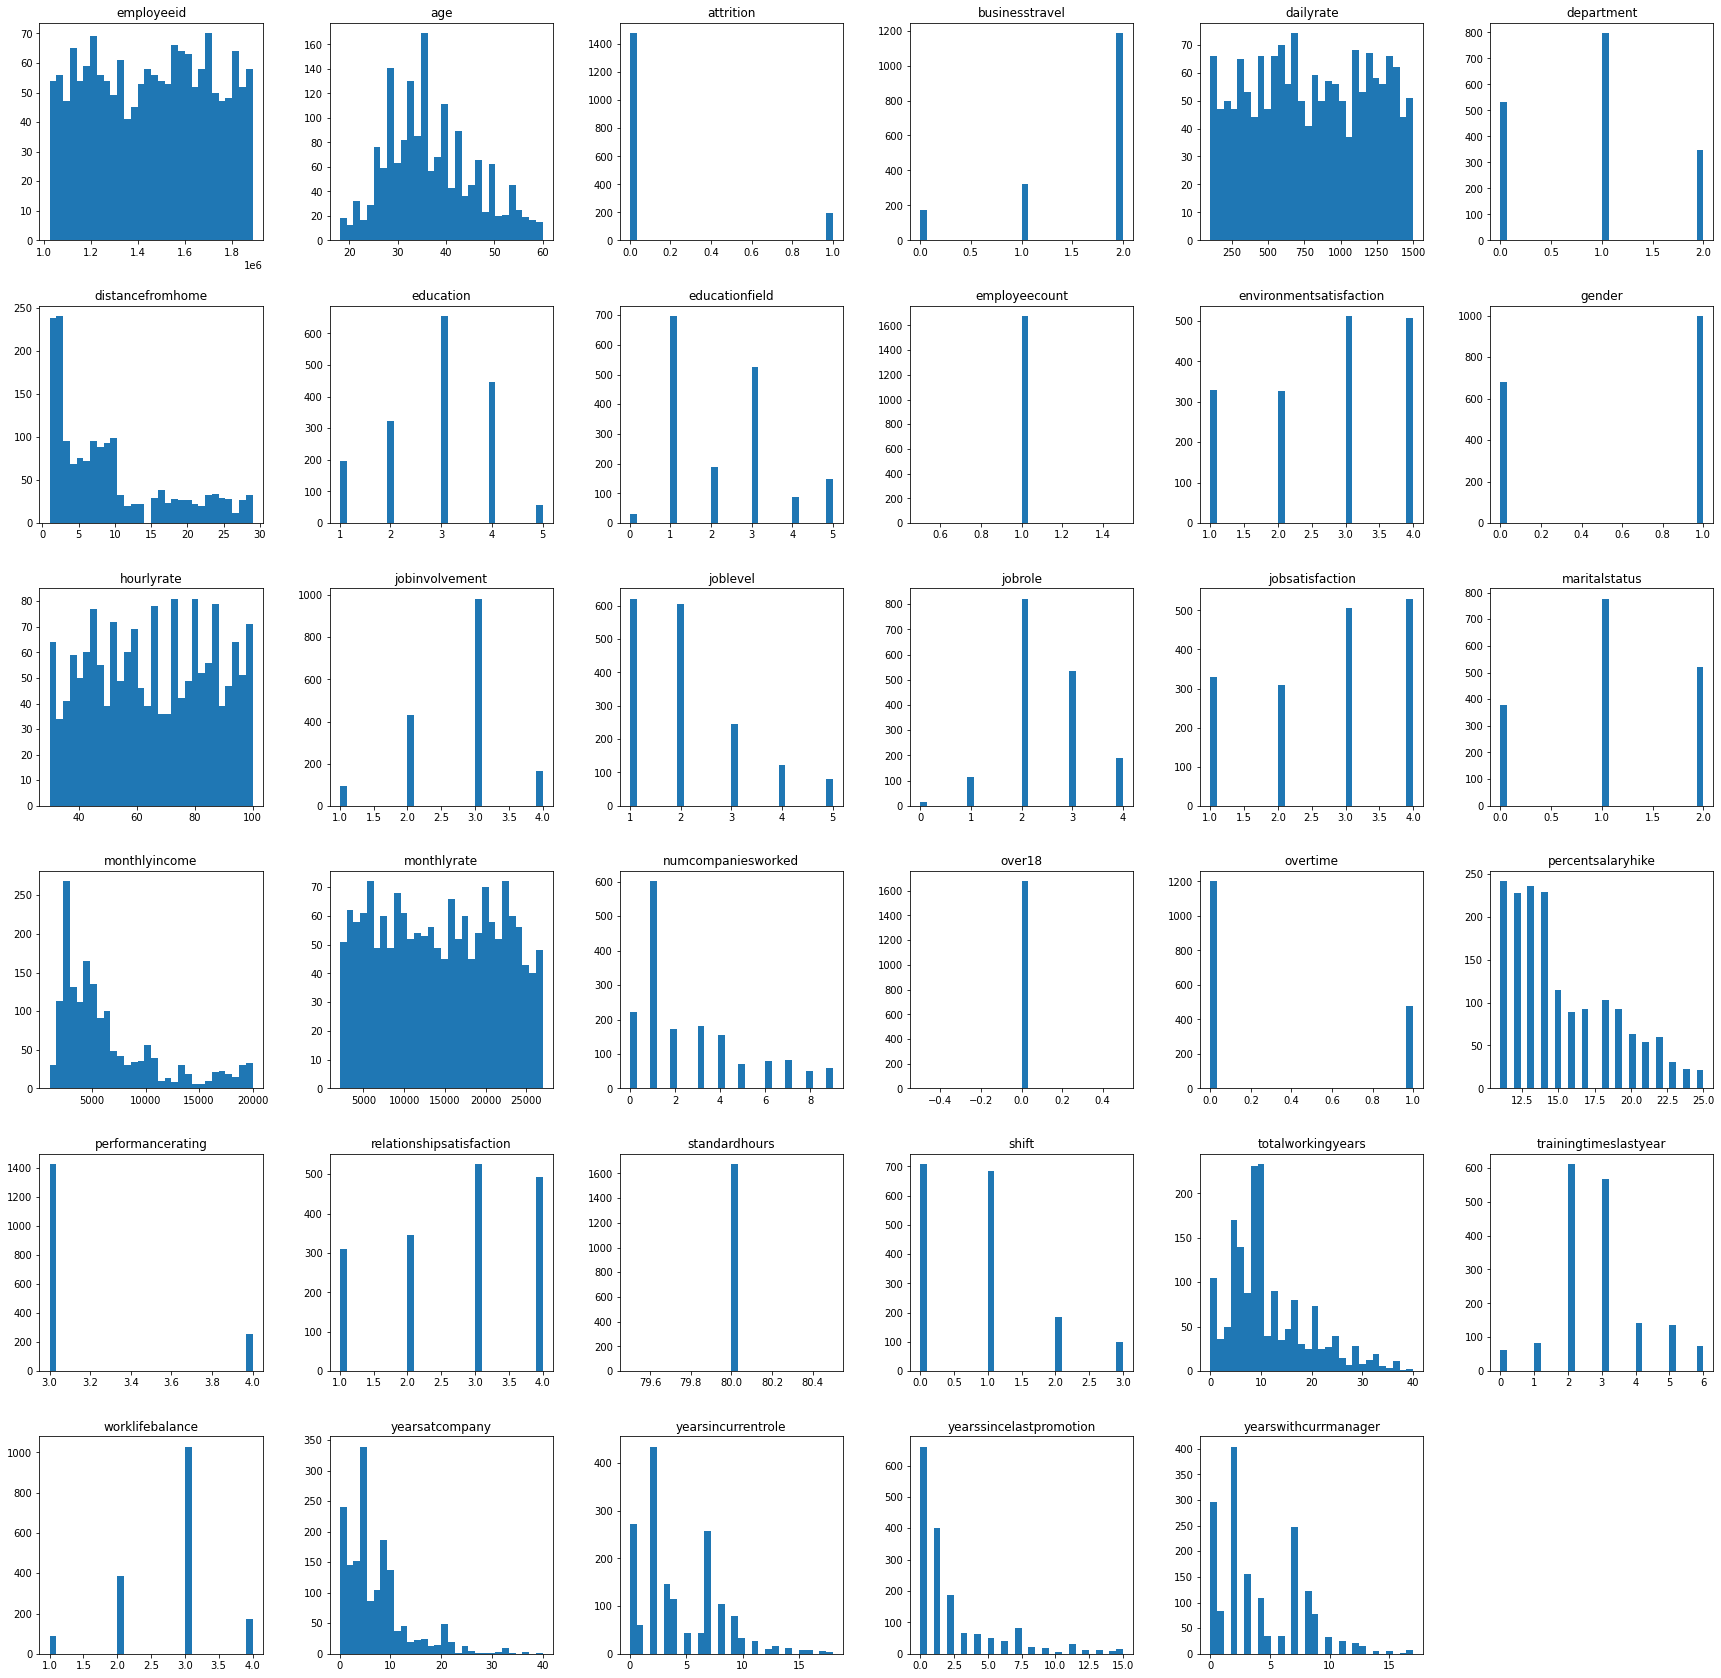

In [10]:
# examining the variables' distributions
df.hist(bins=30, figsize=(30,30), grid=False);

__Insights:__ 
- Several features, including `monthlyincome`, `percentsalaryhike`, `totalworkingyears` and `yearsincurrentrole`, are tail heavy (right-skewed)
- It makes sense to drop `employeecount`, `standardhours` and `over18` since they do not change from one employee to the other
- I will also drop `employeeID` since it is irrelevant to the upcoming analyses

In [11]:
df.drop(['employeeid', 'employeecount', 'standardhours', 'over18'], 
        axis=1, inplace=True)
df.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,shift,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,0,2,1102,0,1,2,1,2,0,94,3,2,2,4,2,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5
1,49,0,1,279,1,8,1,1,3,1,61,2,2,3,2,1,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7
2,37,1,2,1373,1,2,2,4,4,1,92,2,1,2,3,2,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0
3,33,0,1,1392,1,3,4,1,4,0,56,3,1,3,3,1,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0
4,27,0,2,591,1,2,1,3,1,1,40,3,1,2,2,1,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2


In [12]:
# getting the statisitical summary of the data
df.describe()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,shift,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
count,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000
mean,36.866348,0.118735,1.603819,800.557876,0.891408,9.221957,2.907518,2.233890,2.714797,0.595465,65.470167,2.724940,2.066826,2.456444,2.738663,1.086516,6516.512530,14287.019690,2.662291,0.284010,15.196897,3.150358,2.718377,0.806086,11.338902,2.805489,2.766110,7.033413,4.264916,2.200477,4.135442
std,9.129126,0.323573,0.666887,401.594438,0.716641,8.158118,1.025835,1.324469,1.097534,0.490948,20.207572,0.714121,1.113423,0.817649,1.104005,0.727480,4728.456618,7138.857783,2.477704,0.451076,3.646550,0.357529,1.078162,0.855527,7.834996,1.288431,0.702369,6.098991,3.627456,3.229587,3.559662
min,18.000000,0.000000,0.000000,102.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,30.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1009.000000,2094.000000,0.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,1.000000,465.000000,0.000000,2.000000,2.000000,1.000000,2.000000,0.000000,48.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2928.250000,7993.000000,1.000000,0.000000,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,0.000000,2.000000,796.500000,1.000000,7.000000,3.000000,2.000000,3.000000,1.000000,65.500000,3.000000,2.000000,2.000000,3.000000,1.000000,4899.000000,14269.500000,2.000000,0.000000,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,0.000000,2.000000,1157.000000,1.000000,14.000000,4.000000,3.000000,4.000000,1.000000,83.000000,3.000000,3.000000,3.000000,4.000000,2.000000,8380.250000,20462.000000,4.000000,1.000000,18.000000,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,10.000000,7.000000,3.000000,7.000000
max,60.000000,1.000000,2.000000,1499.000000,2.000000,29.000000,5.000000,5.000000,4.000000,1.000000,100.000000,4.000000,5.000000,4.000000,4.000000,2.000000,19999.000000,26999.000000,9.000000,1.000000,25.000000,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


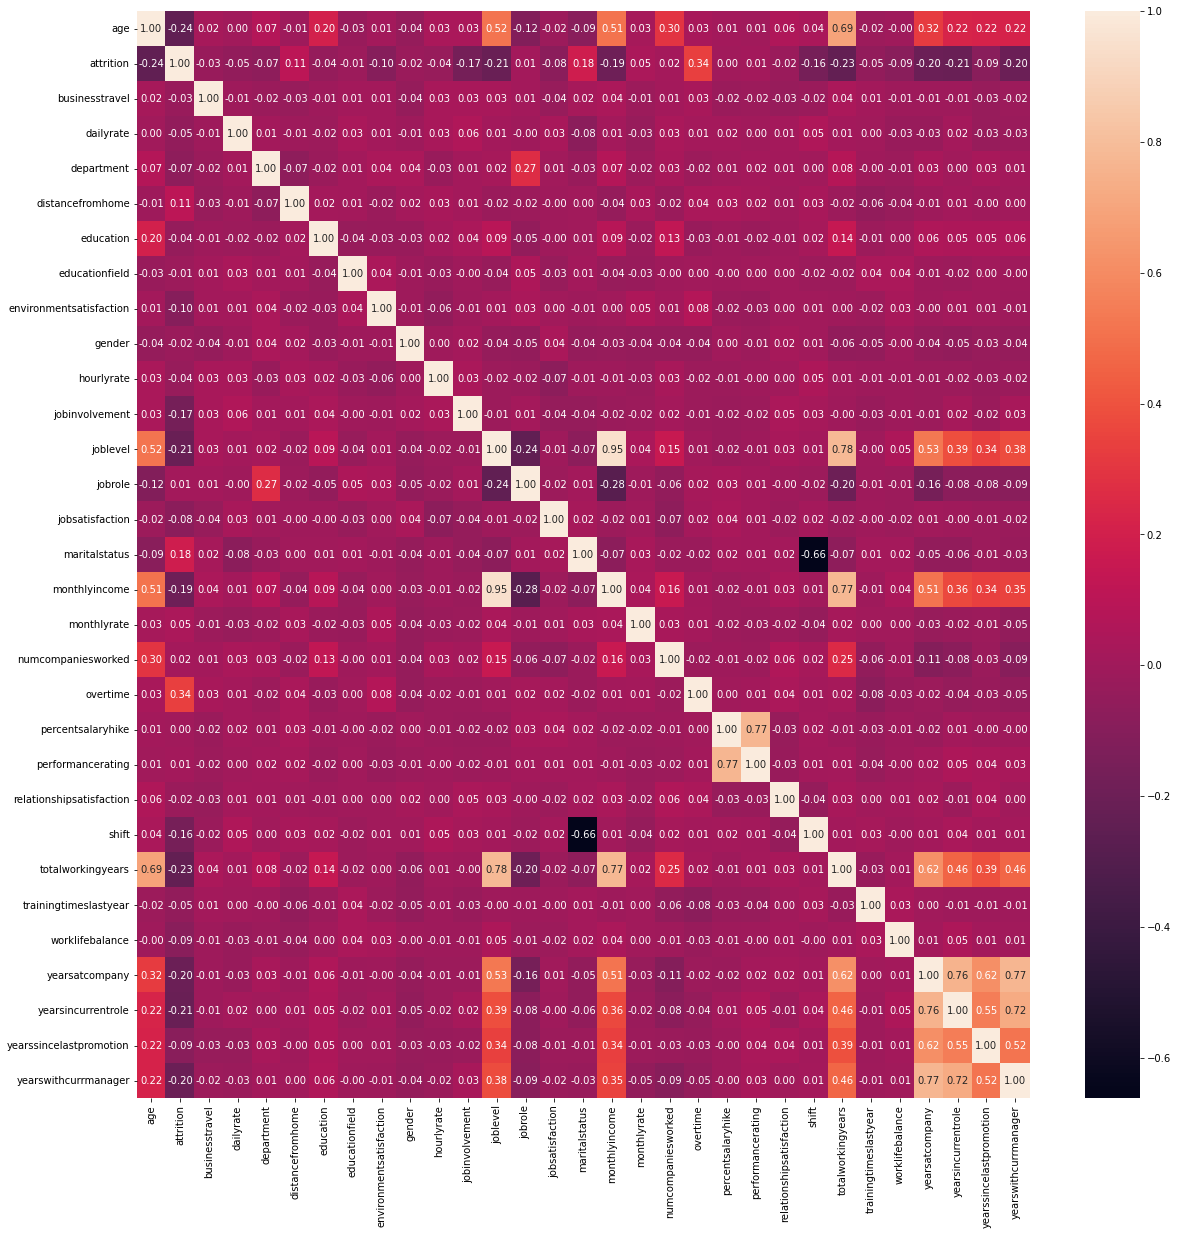

In [13]:
corr = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, fmt='.2f');

In [14]:
# comparing statistical summaries of employees who stayed to those of employees who were not retained 
left_df = df[df['attrition'] == 1]
stayed_df = df[df['attrition'] == 0]

In [15]:
left_df.describe()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,shift,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
count,199.000000,199.0,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.00000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.00000
mean,30.899497,1.0,1.552764,741.613065,0.763819,11.567839,2.798995,2.185930,2.41206,0.567839,63.472362,2.402010,1.437186,2.472362,2.492462,1.452261,4024.246231,15176.427136,2.778894,0.698492,15.226131,3.160804,2.658291,0.437186,6.341709,2.613065,2.592965,3.688442,2.211055,1.442211,2.18593
std,8.860875,0.0,0.640375,392.929410,0.673823,8.814254,0.969119,1.389209,1.17682,0.496626,19.211686,0.797215,0.800772,0.548635,1.109506,0.700997,3089.287935,7286.818858,2.649825,0.460070,3.786489,0.368277,1.074883,0.800772,5.940260,1.285518,0.834938,4.106341,2.598694,2.563423,2.74701
min,18.000000,1.0,0.000000,103.000000,0.000000,1.000000,1.000000,0.000000,1.00000,0.000000,31.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1009.000000,2396.000000,0.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000
25%,25.500000,1.0,1.000000,408.000000,0.000000,3.000000,2.000000,1.000000,1.00000,0.000000,48.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2304.500000,9241.000000,1.000000,0.000000,12.000000,3.000000,2.000000,0.000000,1.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.00000
50%,29.000000,1.0,2.000000,688.000000,1.000000,9.000000,3.000000,2.000000,2.00000,1.000000,63.000000,2.000000,1.000000,2.000000,3.000000,2.000000,2741.000000,15497.000000,1.000000,1.000000,14.000000,3.000000,3.000000,0.000000,5.000000,2.000000,3.000000,2.000000,2.000000,0.000000,2.00000
75%,34.000000,1.0,2.000000,1077.500000,1.000000,19.500000,3.000000,3.000000,3.00000,1.000000,79.000000,3.000000,2.000000,3.000000,3.000000,2.000000,4782.000000,21752.500000,5.000000,1.000000,18.000000,3.000000,4.000000,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,2.000000,3.00000
max,58.000000,1.0,2.000000,1485.000000,2.000000,29.000000,5.000000,5.000000,4.00000,1.000000,100.000000,4.000000,5.000000,4.000000,4.000000,2.000000,19859.000000,26999.000000,9.000000,1.000000,25.000000,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,31.000000,15.000000,14.000000,10.00000


In [16]:
stayed_df.describe()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,shift,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
count,1477.000000,1477.0,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000
mean,37.670278,0.0,1.610697,808.499661,0.908599,8.905890,2.922139,2.240352,2.755586,0.599188,65.739336,2.768450,2.151659,2.454299,2.771835,1.037238,6852.301963,14167.187542,2.646581,0.228165,15.192959,3.148951,2.726473,0.855789,12.012187,2.831415,2.789438,7.484089,4.541638,2.302640,4.398104
std,8.865543,0.0,0.670290,402.218027,0.720707,8.016494,1.032679,1.315860,1.080364,0.490229,20.329245,0.691023,1.122578,0.847508,1.099430,0.717074,4810.634808,7112.697801,2.454120,0.419792,3.628591,0.356160,1.078710,0.850746,7.817263,1.287058,0.679508,6.183775,3.658036,3.296516,3.575731
min,18.000000,0.0,0.000000,102.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,30.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1051.000000,2094.000000,0.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,0.0,1.000000,471.000000,0.000000,2.000000,2.000000,1.000000,2.000000,0.000000,48.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3294.000000,7770.000000,1.000000,0.000000,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,0.0,2.000000,809.000000,1.000000,7.000000,3.000000,2.000000,3.000000,1.000000,66.000000,3.000000,2.000000,2.000000,3.000000,1.000000,5204.000000,14034.000000,2.000000,0.000000,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,6.000000,3.000000,1.000000,3.000000
75%,44.000000,0.0,2.000000,1172.000000,1.000000,13.000000,4.000000,3.000000,4.000000,1.000000,83.000000,3.000000,3.000000,3.000000,4.000000,2.000000,8858.000000,20308.000000,4.000000,0.000000,18.000000,3.000000,4.000000,1.000000,16.000000,3.000000,3.000000,10.000000,7.000000,3.000000,7.000000
max,60.000000,0.0,2.000000,1499.000000,2.000000,29.000000,5.000000,5.000000,4.000000,1.000000,100.000000,4.000000,5.000000,4.000000,4.000000,2.000000,19999.000000,26997.000000,9.000000,1.000000,25.000000,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


__Insights:__<br>

- `age`: The mean age of the employees who stayed is higher compared to who left
- `dailyrate`: Rate of employees who stayed is higher
- `distancefromhome`: Employees who stayed live closer to home 
- `environmentsatisfaction` & `jobsatisfaction`: Employees who stayed are generally more satisifed with their jobs

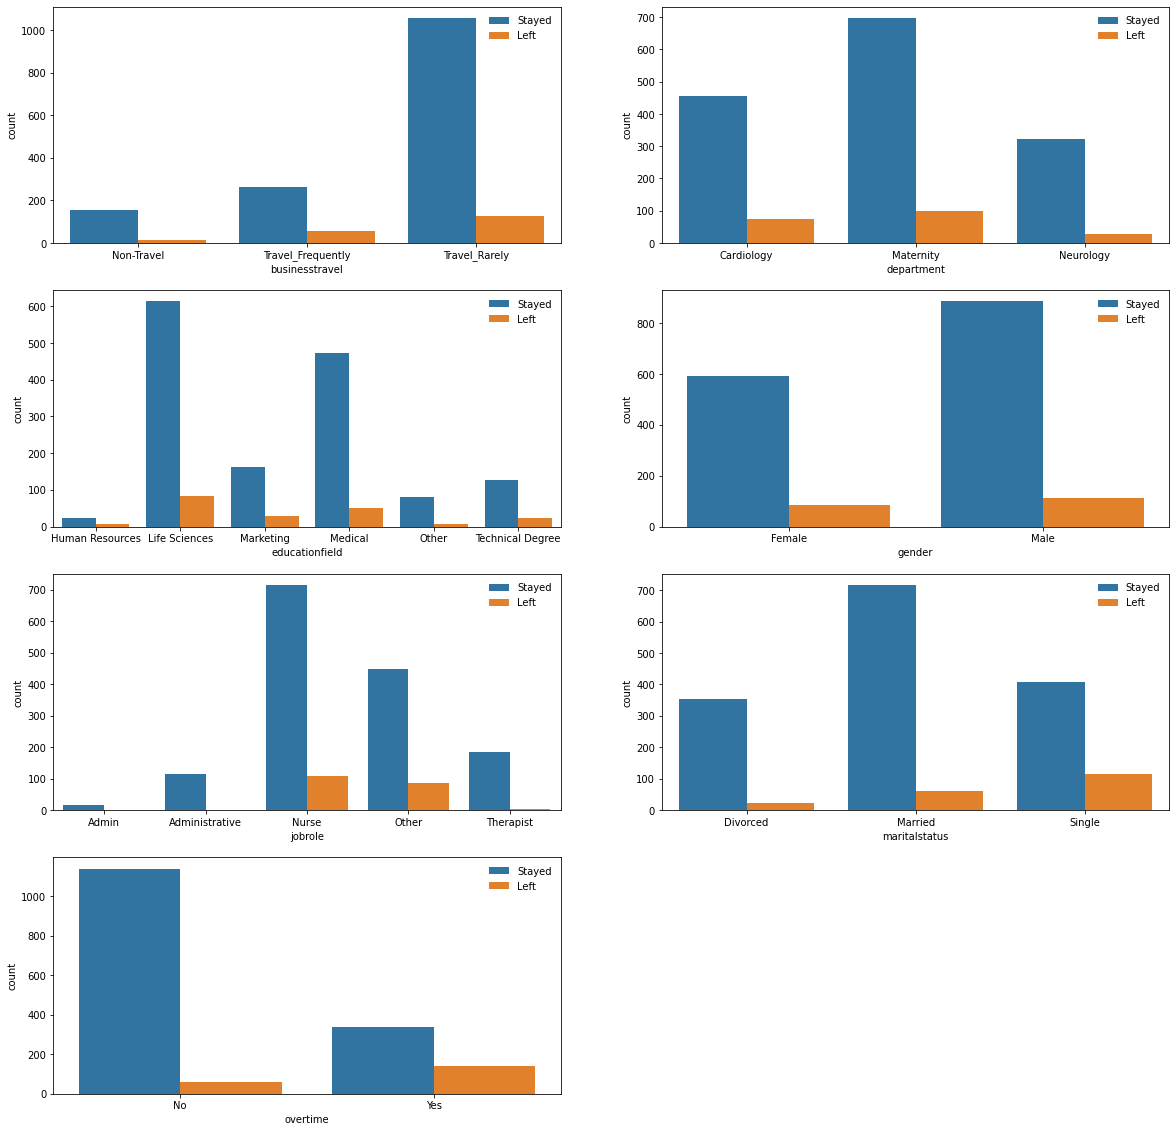

In [17]:
cols = ['businesstravel', 'department', 'educationfield', 
        'gender', 'jobrole', 'maritalstatus', 'overtime']

ticklabels = {'businesstravel': ['Non-Travel', 'Travel_Frequently', 'Travel_Rarely'],
              'department': ['Cardiology', 'Maternity', 'Neurology'],
              'educationfield': ['Human Resources', 'Life Sciences', 'Marketing', 
                                 'Medical', 'Other', 'Technical Degree'],
              'gender': ['Female', 'Male'],
              'jobrole': ['Admin', 'Administrative', 'Nurse', 'Other', 'Therapist'],
              'maritalstatus': ['Divorced', 'Married', 'Single'],
              'overtime': ['No', 'Yes']}

plt.figure(figsize=(20,20))
for n, col in enumerate(cols):
  ax = plt.subplot(4, 2, n + 1)
  sns.countplot(x=col, hue='attrition', data=df)
  ax.set_xticklabels(ticklabels[col])
  plt.legend(frameon=False, labels=['Stayed', 'Left'])

plt.show()

__Insights:__
- Single employees tend to leave compared to married and divorced
- Nurses tend to leave compared to any other job 
- The maternity department has the highest attrition count
- Employees who work overtime are more likely to leave than those who don't

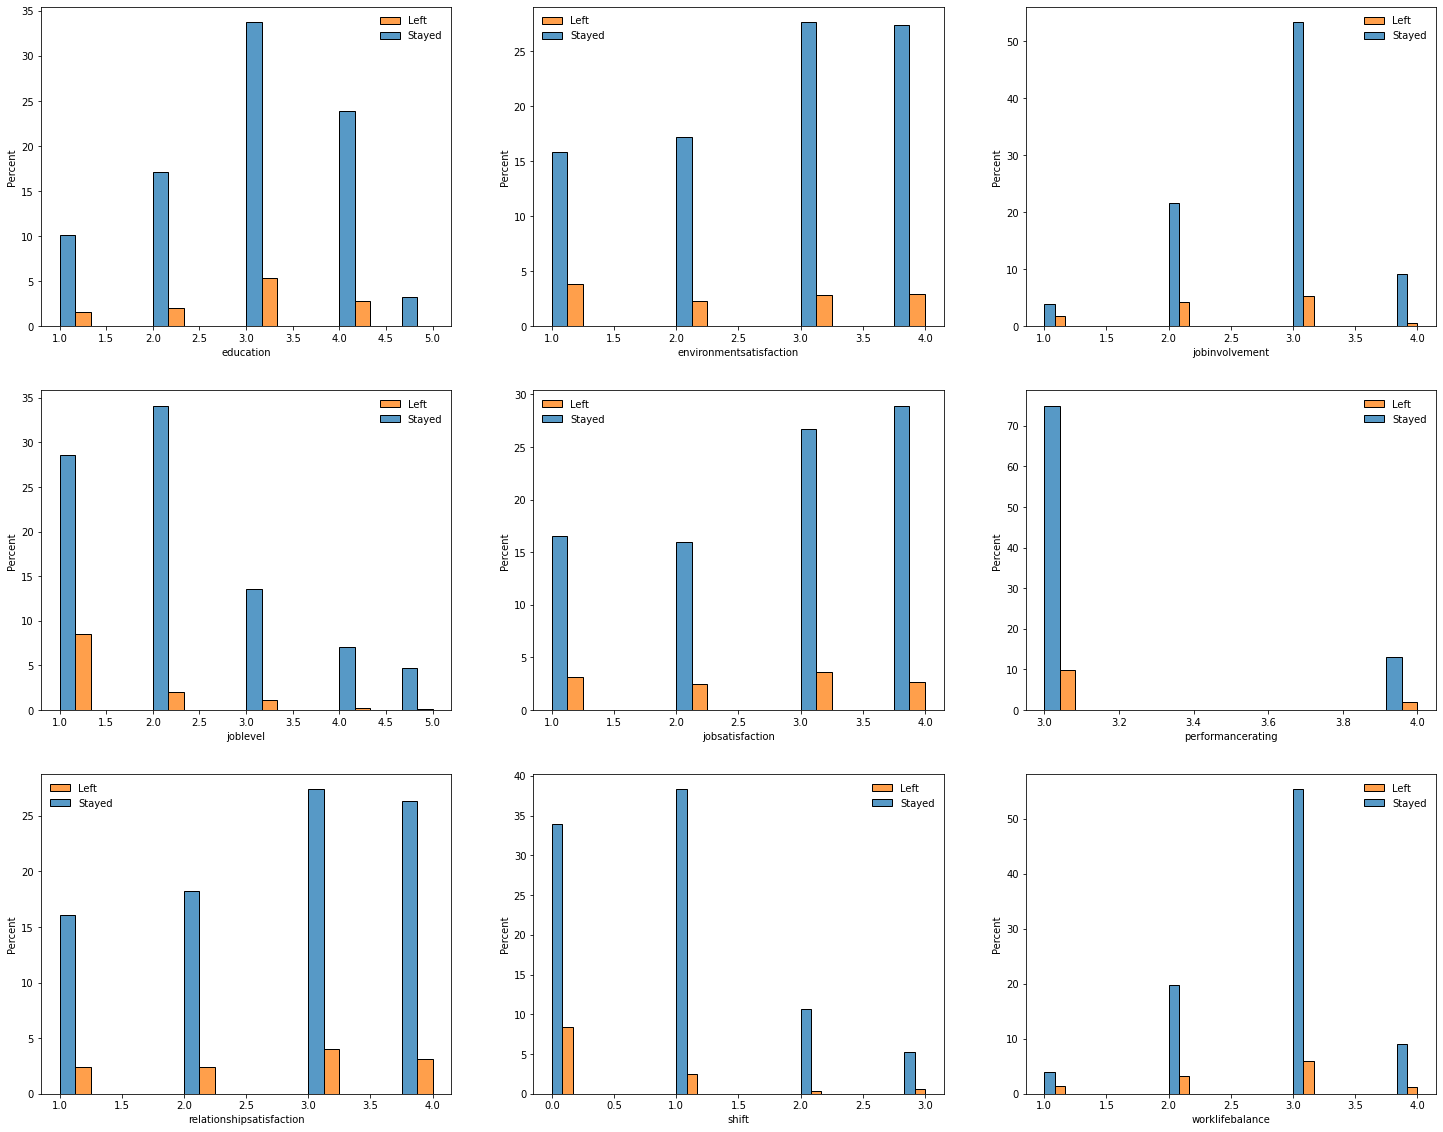

In [18]:
cols = ['education', 'environmentsatisfaction', 'jobinvolvement',
        'joblevel', 'jobsatisfaction', 'performancerating', 
        'relationshipsatisfaction', 'shift', 'worklifebalance']

plt.figure(figsize=(25,20))
for n, col in enumerate(cols):
  ax = plt.subplot(3, 3, n + 1)
  sns.histplot(x=col, hue='attrition', data=df, stat='percent', multiple="dodge")
  plt.legend(frameon=False, labels=['Left', 'Stayed'])

plt.show()

__Insights:__<br>
- Less involved employees tend to leave
- Less experienced (low job level) tend to leave
- Employees who work the morning shift are more likely to leave

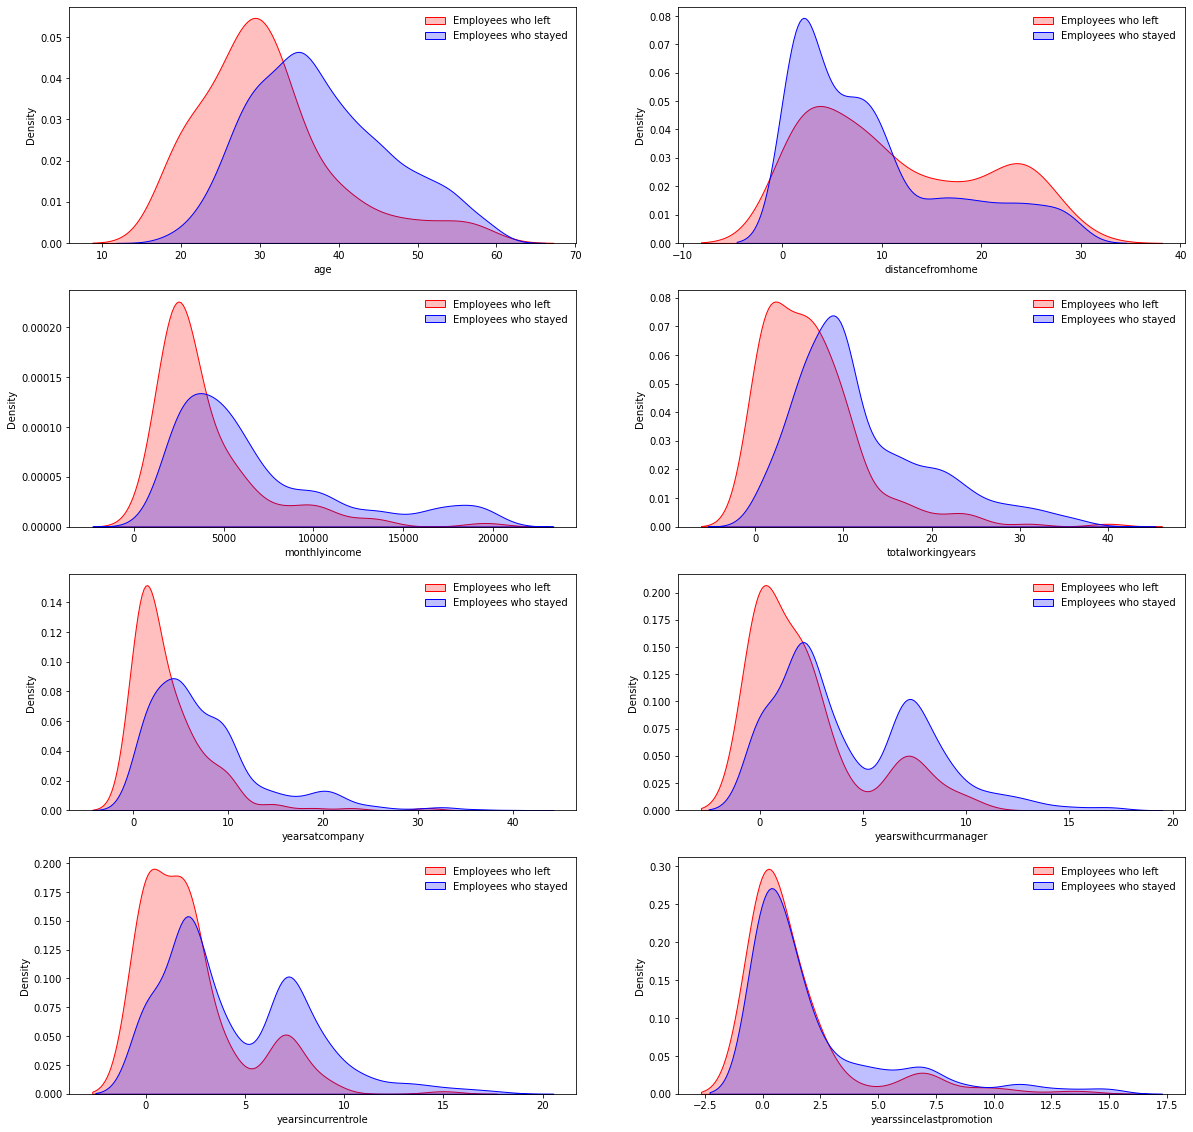

In [19]:
cols = ['age','distancefromhome','monthlyincome','totalworkingyears','yearsatcompany',
        'yearswithcurrmanager','yearsincurrentrole','yearssincelastpromotion']

plt.figure(figsize=(20,20))
for n, col in enumerate(cols):
  ax = plt.subplot(4, 2, n + 1)
  sns.kdeplot(left_df[col], label='Employees who left', shade=True, color='r', ax=ax)
  sns.kdeplot(stayed_df[col], label='Employees who stayed', shade=True, color='b', ax=ax)
  plt.legend(frameon=False)

__Insights:__<br>
It is difficult to tease out differences between employees who were retained and those who left based on the numerical features above, using a visual inpection of their distributions

## Clustering Analysis

In [20]:
# creating a copy of the dataframe to maintain its integrity
df1 = df.copy()

### Data Preparation

In [21]:
# feature scaling
ms = MinMaxScaler()
df1 = ms.fit_transform(df1)
df1 = pd.DataFrame(df1, columns=df.columns.to_list())
df1.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,shift,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,0.547619,0.0,1.0,0.715820,0.0,0.000000,0.25,0.2,0.333333,0.0,0.914286,0.666667,0.25,0.50,1.000000,1.0,0.262454,0.698053,0.888889,1.0,0.000000,0.0,0.000000,0.000000,0.200,0.0,0.000000,0.15,0.222222,0.000000,0.294118
1,0.738095,0.0,0.5,0.126700,0.5,0.250000,0.00,0.2,0.666667,1.0,0.442857,0.333333,0.25,0.75,0.333333,0.5,0.217009,0.916001,0.111111,0.0,0.857143,1.0,1.000000,0.333333,0.250,0.5,0.666667,0.25,0.388889,0.066667,0.411765
2,0.452381,1.0,1.0,0.909807,0.5,0.035714,0.25,0.8,1.000000,1.0,0.885714,0.333333,0.00,0.50,0.666667,1.0,0.056925,0.012126,0.666667,1.0,0.285714,0.0,0.333333,0.000000,0.175,0.5,0.666667,0.00,0.000000,0.000000,0.000000
3,0.357143,0.0,0.5,0.923407,0.5,0.071429,0.75,0.2,1.000000,0.0,0.371429,0.666667,0.00,0.75,0.666667,0.5,0.100053,0.845814,0.111111,1.0,0.000000,0.0,0.666667,0.000000,0.200,0.5,0.666667,0.20,0.388889,0.200000,0.000000
4,0.214286,0.0,1.0,0.350036,0.5,0.035714,0.00,0.6,0.000000,1.0,0.142857,0.666667,0.00,0.50,0.333333,0.5,0.129489,0.583738,1.000000,0.0,0.071429,0.0,1.000000,0.333333,0.150,0.5,0.666667,0.05,0.111111,0.133333,0.117647


In [22]:
# three lists to hold feature names, correlation and p-values
cols = df1.columns.to_list()
cols.remove('attrition')
corr_vals = []
p_vals = []

# calculating the pearson correlation between attrition and all other features
for i in cols:
  corr, p_values = scipy.stats.pearsonr(df['attrition'], df[i])
  corr_vals.append(corr)
  p_vals.append(p_values)

# dataframe inputs
table_cols = ['feature', 'correlation', 'p_value']
table_vals = [cols, corr_vals, p_vals]
table_dict = {}

for i in range(len(table_cols)):
    table_dict[table_cols[i]] = table_vals[i]

table = pd.DataFrame(table_dict)
table

,feature,correlation,p_value
0,age,-0.239984,2.205986e-23
1,businesstravel,-0.028109,2.500879e-01
2,dailyrate,-0.053892,2.736733e-02
3,department,-0.065370,7.427503e-03
4,distancefromhome,0.105580,1.482804e-05
5,education,-0.038843,1.119260e-01
6,educationfield,-0.013296,5.864918e-01
7,environmentsatisfaction,-0.101278,3.270133e-05
8,gender,-0.020661,3.979437e-01
9,hourlyrate,-0.036300,1.374220e-01


In [23]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   feature      30 non-null     object 
 1   correlation  30 non-null     float64
 2   p_value      30 non-null     float64
dtypes: float64(2), object(1)
memory usage: 848.0+ bytes


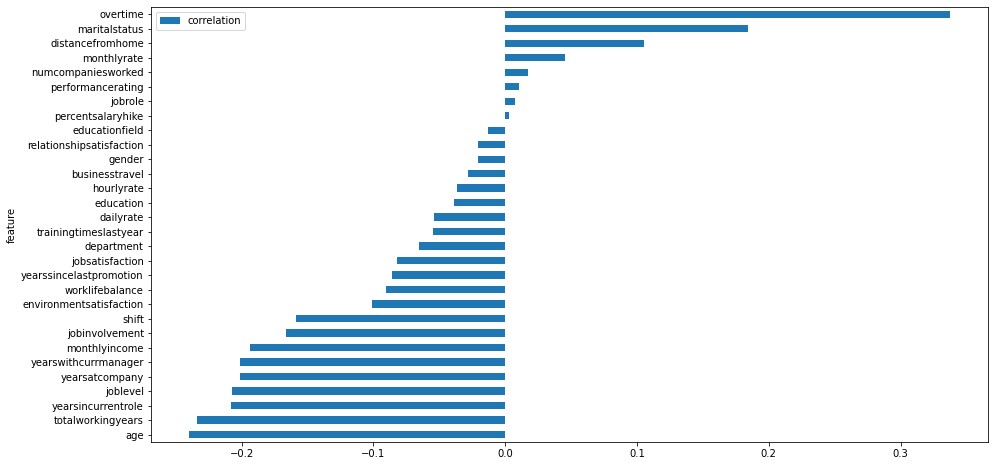

In [24]:
# sort values by correlation scores in asending order to evaluate significance
table.sort_values(by='correlation').plot(figsize=(15,8), kind='barh', x='feature', y='correlation');

__Insights:__<br>
There is a very low correlation between attrition and other features in the dataset. To make more meaningful conclusions, I will investigate the trends between attrition and features with an absolute correlation score of 0.2 of higher i.e., c >= 0.2 and c <= -0.2

In [25]:
features = table['feature'].loc[(table['correlation'] <= -0.2) | (table['correlation'] >= 0.2)].tolist()
features

['age',
 'joblevel',
 'overtime',
 'totalworkingyears',
 'yearsatcompany',
 'yearsincurrentrole',
 'yearswithcurrmanager']

### Finding the optimal number of clusters using the Elbow Method

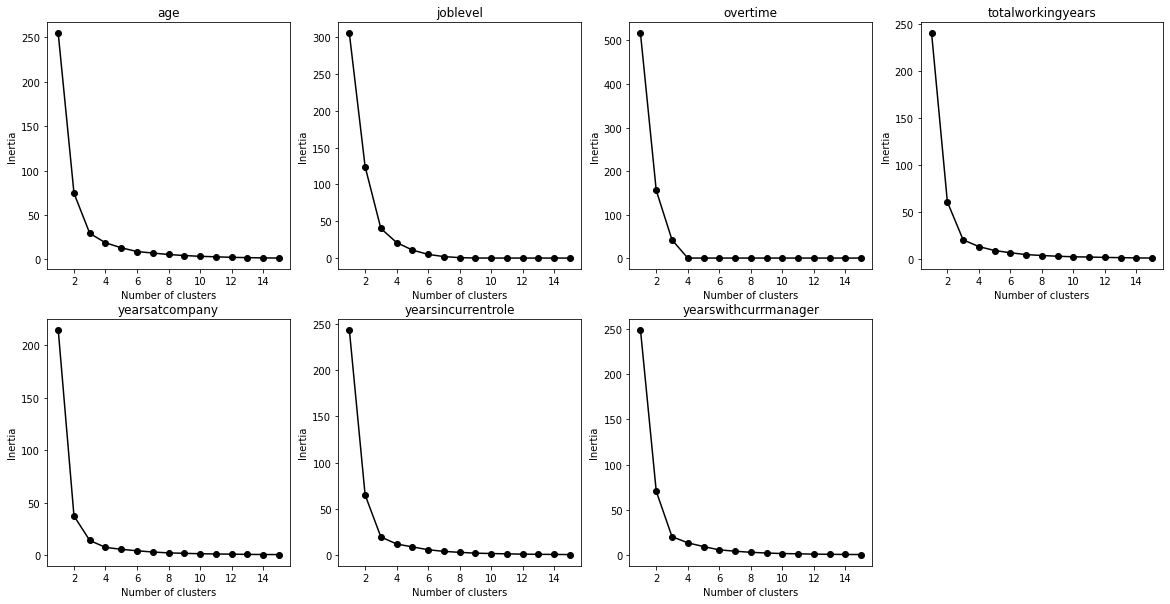

In [26]:
plt.figure(figsize = (20,10))

# Find the optimal n for each feature, test range 1 to 15
for n, feature in enumerate(features):
  c_number = range(1, 16)
  inertia = []
  for c in c_number:
    kmeans = KMeans(n_clusters = c)
    kmeans.fit(df1[['attrition', feature]])
    inertia.append(kmeans.inertia_)
  ax = plt.subplot(2, 4, n + 1)
  ax.plot(c_number, inertia, 'o-', c='k')
  ax.set_xlabel('Number of clusters')
  ax.set_ylabel('Inertia')
  ax.set_title(feature)

plt.show()

__Insight:__<br>
According to the analysis above, the optimal number of clusters is 3 across all features. 

### Clustering with KMeans

In [27]:
# defining fields to be used in the clustering analysis
cols = features.copy()
cols.insert(0, 'attrition')

# model training
kmeans = KMeans(n_clusters=3)
kmeans.fit(df1[cols])

# appending the clusters to the df
df1 = df.copy()
df1['clusters'] = kmeans.labels_
df1.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,shift,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,clusters
0,41,0,2,1102,0,1,2,1,2,0,94,3,2,2,4,2,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0
1,49,0,1,279,1,8,1,1,3,1,61,2,2,3,2,1,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,1
2,37,1,2,1373,1,2,2,4,4,1,92,2,1,2,3,2,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,2
3,33,0,1,1392,1,3,4,1,4,0,56,3,1,3,3,1,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,0
4,27,0,2,591,1,2,1,3,1,1,40,3,1,2,2,1,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,1


In [28]:
# cluster distribution within the attrited employee group
left = df1[df1['attrition'] == 1]
left['clusters'].value_counts()

2    197
0      1
1      1
Name: clusters, dtype: int64

In [29]:
stayed = df1[df1['attrition'] == 0]
stayed['clusters'].value_counts()

1    1140
0     337
Name: clusters, dtype: int64

__Insight:__ Employees who left the hospital are found in cluster 2

### Exploring the differences amongst the clusters

In [30]:
df1[df1['clusters'] == 2].describe()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,shift,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,clusters
count,197.000000,197.0,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.0
mean,30.680203,1.0,1.553299,742.142132,0.766497,11.629442,2.791878,2.197970,2.401015,0.563452,63.543147,2.406091,1.406091,2.482234,2.492386,1.451777,3901.741117,15077.076142,2.736041,0.700508,15.263959,3.162437,2.649746,0.441624,6.076142,2.614213,2.598985,3.451777,2.131980,1.319797,2.116751,2.0
std,8.613839,0.0,0.641627,392.784448,0.674835,8.830591,0.970133,1.391078,1.176556,0.497221,19.123776,0.793830,0.740631,0.540162,1.114008,0.702735,2835.250923,7255.749373,2.628605,0.459203,3.786573,0.369791,1.075783,0.803623,5.293362,1.291021,0.830907,3.356985,2.437555,2.266496,2.671003,0.0
min,18.000000,1.0,0.000000,103.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,31.000000,1.000000,1.000000,2.000000,1.000000,0.000000,1009.000000,2396.000000,0.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,25.000000,1.0,1.000000,408.000000,0.000000,3.000000,2.000000,1.000000,1.000000,0.000000,48.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2302.000000,9241.000000,1.000000,0.000000,12.000000,3.000000,2.000000,0.000000,1.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,2.0
50%,29.000000,1.0,2.000000,688.000000,1.000000,9.000000,3.000000,2.000000,2.000000,1.000000,63.000000,2.000000,1.000000,2.000000,3.000000,2.000000,2741.000000,15346.000000,1.000000,1.000000,14.000000,3.000000,3.000000,0.000000,5.000000,2.000000,3.000000,2.000000,2.000000,0.000000,2.000000,2.0
75%,34.000000,1.0,2.000000,1076.000000,1.000000,20.000000,3.000000,3.000000,3.000000,1.000000,79.000000,3.000000,2.000000,3.000000,3.000000,2.000000,4736.000000,21534.000000,5.000000,1.000000,18.000000,3.000000,4.000000,1.000000,9.000000,3.000000,3.000000,5.000000,2.000000,2.000000,3.000000,2.0
max,58.000000,1.0,2.000000,1485.000000,2.000000,29.000000,5.000000,5.000000,4.000000,1.000000,100.000000,4.000000,5.000000,4.000000,4.000000,2.000000,19859.000000,26999.000000,9.000000,1.000000,25.000000,4.000000,4.000000,3.000000,31.000000,6.000000,4.000000,19.000000,9.000000,11.000000,10.000000,2.0


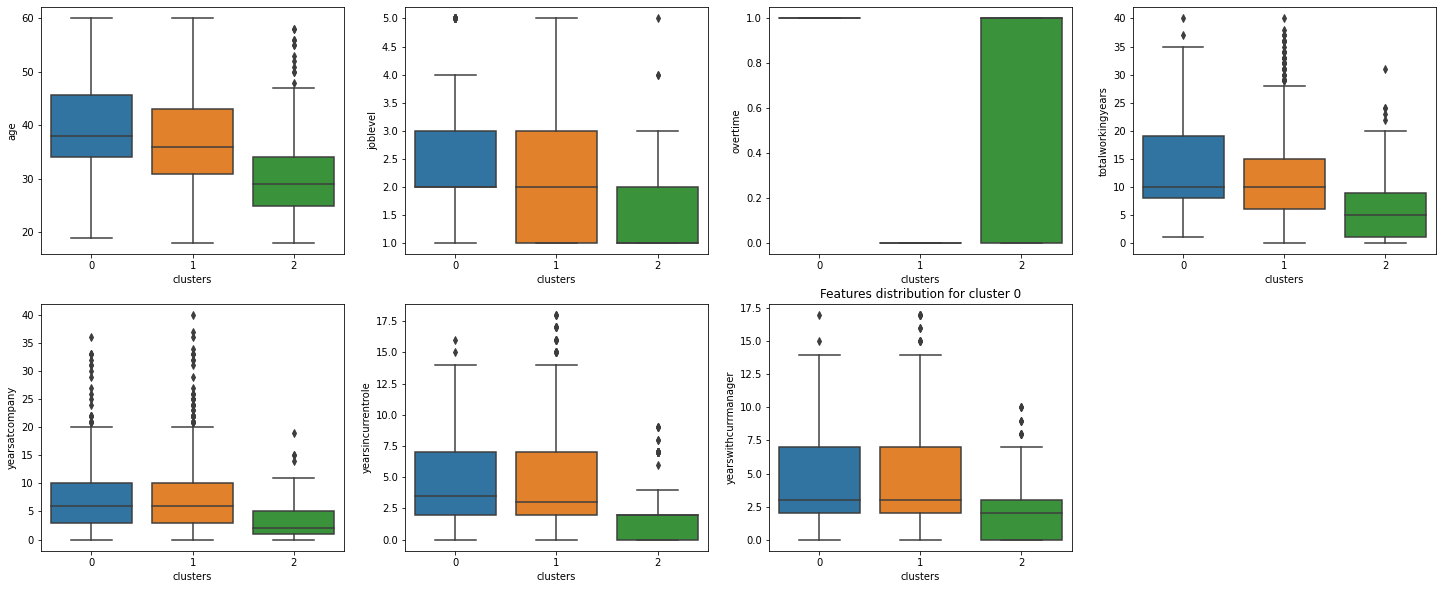

In [31]:
plt.figure(figsize=(25, 10))

for n, feature in enumerate(features):
  ax = plt.subplot(2, 4, n + 1)
  sns.boxplot(ax=ax, data=df1, x='clusters', y=feature)

plt.title('Features distribution for cluster 0')
plt.show()

### Conclusions

In general, employees who tend to leave the hospital are younger (average age = 30 years old), entry-level personel that have not been working for a long time (with the hospital or elsewhere). Interestingly, overtime did not play a huge role in attrition, as the distribution of personel across the cluster is evenly split for this feature

## Regression Analysis

In [32]:
# copying the df to maintain its integrity
df2 = df.copy()
df2.head()

,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,shift,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,41,0,2,1102,0,1,2,1,2,0,94,3,2,2,4,2,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5
1,49,0,1,279,1,8,1,1,3,1,61,2,2,3,2,1,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7
2,37,1,2,1373,1,2,2,4,4,1,92,2,1,2,3,2,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0
3,33,0,1,1392,1,3,4,1,4,0,56,3,1,3,3,1,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0
4,27,0,2,591,1,2,1,3,1,1,40,3,1,2,2,1,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2


__Note:__ From the clustering analysis, I know that certain features are more correlated with attrition than others. Therefore, I will use these pre-identified features to predict attrition in a more purposeful manner

In [33]:
X = df2[features]
y = df2['attrition']

In [34]:
X.head()

,age,joblevel,overtime,totalworkingyears,yearsatcompany,yearsincurrentrole,yearswithcurrmanager
0,41,2,1,8,6,4,5
1,49,2,0,10,10,7,7
2,37,1,1,7,0,0,0
3,33,1,1,8,8,7,0
4,27,1,0,6,2,2,2


In [35]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: attrition, dtype: int8

In [36]:
# scaling the data to prevent bias
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [37]:
print(X.shape, y.shape)

(1676, 7) (1676,)


In [38]:
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
print(X_train.shape, X_test.shape)

(1257, 7) (419, 7)


In [39]:
# training the logistic regression model
model_log = LogisticRegression()
model_log.fit(X_train, y_train)

# calculating predictions
y_pred_log = model_log.predict(X_test)

# evaluating model performance
print("Accuracy {} %".format( 100 * accuracy_score(y_pred_log, y_test)))
print(classification_report(y_test, y_pred_log))

Accuracy 90.45346062052506 %
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       365
           1       0.85      0.31      0.46        54

    accuracy                           0.90       419
   macro avg       0.88      0.65      0.70       419
weighted avg       0.90      0.90      0.88       419



In [40]:
# training the xgboost model
model_xgb = XGBClassifier(use_label_encoder=False)
model_xgb.fit(X_train, y_train)

# calculating predictions
y_pred_xgb = model_xgb.predict(X_test)

# evaluating model performance
print("Accuracy {} %".format( 100 * accuracy_score(y_pred_xgb, y_test)))
print(classification_report(y_test, y_pred_xgb))

Accuracy 91.64677804295943 %
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       365
           1       0.77      0.50      0.61        54

    accuracy                           0.92       419
   macro avg       0.85      0.74      0.78       419
weighted avg       0.91      0.92      0.91       419



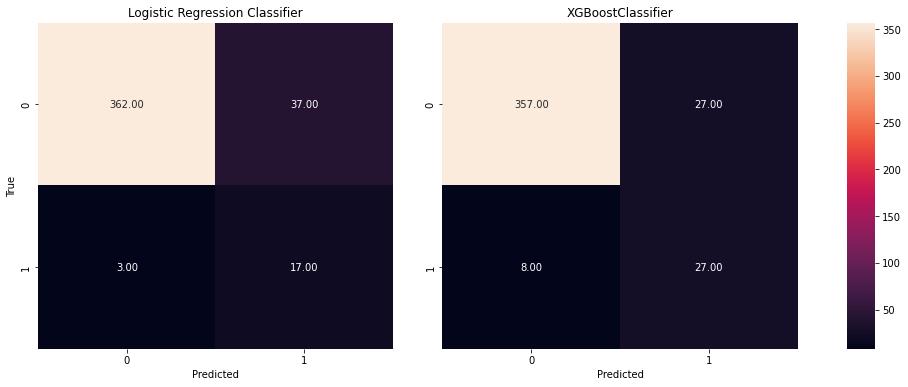

In [41]:
# visualizing the classifiers' performance with confusion matrices

cm1 = confusion_matrix(y_pred_log, y_test)
cm2 = confusion_matrix(y_pred_xgb, y_test)

fig, axs = plt.subplots(1, 3, figsize=(15,6), 
                        gridspec_kw={'width_ratios':[1,1,0.08]})

axs[0].get_shared_y_axes().join(axs[1])

sns.heatmap(cm1, annot=True, fmt='.2f', ax=axs[0], cbar=False)
sns.heatmap(cm2, annot=True, fmt='.2f', ax=axs[1], cbar_ax=axs[2])

axs[0].set_ylabel('True')
axs[0].set_xlabel('Predicted')
axs[1].set_xlabel('Predicted')
axs[0].set_title('Logistic Regression Classifier')
axs[1].set_title('XGBoostClassifier')
plt.show()

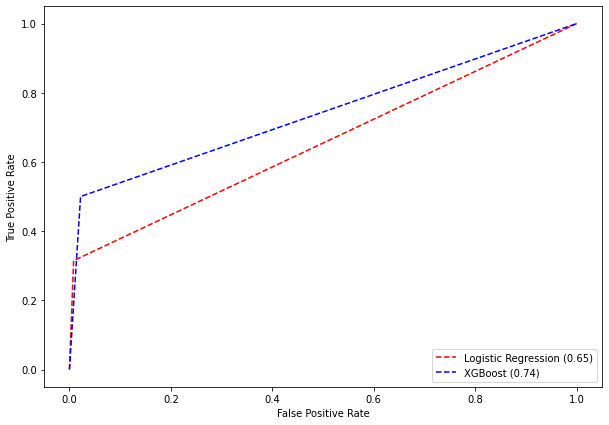

In [42]:
# visualizing the classifiers' performance with a roc curve

fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred_log)
fpr2, tpr2, thresh2 = roc_curve(y_test, y_pred_xgb)

roc_auc_log = auc(fpr1, tpr1)
roc_auc_xgb = auc(fpr2, tpr2)

display_log = RocCurveDisplay(fpr=fpr1, tpr=tpr1, roc_auc=roc_auc_log)
display_xgb = RocCurveDisplay(fpr=fpr2, tpr=tpr2, roc_auc=roc_auc_xgb)


fig, ax = plt.subplots(1, 1, figsize=(10, 7))
display_log.plot(ax=ax, c='r', ls='--', label='Logistic Regression ({})'.format(round(roc_auc_log, 2)))
display_xgb.plot(ax=ax, c='b', ls='--', label='XGBoost ({})'.format(round(roc_auc_xgb, 2)))
plt.show()


### Conclusions
Overall, both classifiers performed well, with high accuracy scores (~90%). Nevertheless, the XGBoost model had better recall tan the Logistic regression model, making it the recommended option for this analysis.